# reach_analysis_A.ipynb

Learn to reach, perform radial reaches, and do the analyses that concern the characteristics of the reach.

In [1]:
%cd /home/z/projects/draculab/

/home/z/projects/draculab


In [2]:
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter

In [3]:
# load a parameter configuration
import pickle
fname = '/home/z/Dropbox (OIST)/saves/gene_2021-06-17'
with (open(fname, "rb")) as f:
    pop = pickle.load(f)
    f.close()

In [4]:
# Configure the simulation
np.random.seed(123456) # always the same random values
np.random.seed() # arbitrary random seed

cfg = pop[0] # parameter configuration to use

n_reaches_l = 16 # number of targets presented for initial learning
use_syne = False # whether to use the version of the network with "synergies"
set_C_delay = False # whether set C_cid using analytical approach
rand_targets = True # whether to train using a large number of random targets
C_noise = True # whether C units are noisy (use euler_maru integrator)
M__C_rand_w = True # whether to randomly intialize weights for the M__C connections
permute_targets = True # whether to permut target order during radial reaches
t_pres_l = cfg['t_pres'] # target presentation time during initial learning
par_heter = cfg['par_heter']
M_size = 12 # number of units in the M population
SPF_size = 12 # number of units in the SPF population

In [5]:
cfg

{'A__M_w_max_frac': 0.225,
 'A__M_w_sum': 2.0,
 'C_adapt_amp': 4.4,
 'C_cid': 0.14928385685463597,
 'C_sigma': 0.6235117516563925,
 'M_cid': 1.069072715299579,
 'M_des_out_w_abs_sum': 3.107279886064089,
 'g_e_factor': 3.0,
 'C_slope': 2.2675408763677987,
 'C_thresh': 0.8919820536944196,
 'C_tau': 0.26003435786600343,
 'C_tau_slow': 21.0,
 'A__M_lrate': 8.0,
 'AL_thresh': 0.55,
 'b_e': 1.0,
 'C__C_antag': 1.5,
 'C__C_p_antag': 0.25,
 'C__C_p_syne': 0.3,
 'C__C_syne': 1.0,
 'CE__CI_w': 0.5,
 'CI__CE_w': -1.3,
 'M__C_lrate': 300.0,
 'M__C_w_sum': 2.3,
 'M__M_w': -0.5,
 'SPF__SPF_w': -1.5,
 'fitness': 0.041630394730014376,
 'n_evals': 1,
 't_pres': 40,
 'par_heter': 0.01,
 'g_e_03': 20.0,
 'CI_slope': 4.158365408276022,
 'CI_tau': 0.09203223283805521,
 'CI_thresh': 1.4,
 'II_g_03': 6.4857818119346735,
 'M_tau': 0.01,
 'SF_thresh_03': 0.4}

In [6]:
# Create the network
%cd /home/z/projects/draculab/notebook/spinal/
from v3ft3p2ph2_net import *
%cd ../..

if not use_syne:
    net, pops_dict, hand_coords, m_idxs = net_from_cfg(cfg,
                                                       t_pres = t_pres_l,
                                                       par_heter = par_heter,
                                                       set_C_delay = set_C_delay,
                                                       rand_targets = rand_targets,
                                                       track_weights = True,
                                                       track_ips = True,
                                                       C_noise = C_noise,
                                                       M__C_rand_w = M__C_rand_w)
else:
    net, pops_dict, hand_coords, m_idxs = syne_net(cfg,
                                                   t_pres = t_pres,
                                                   par_heter = par_heter,
                                                   set_C_delay = set_C_delay,
                                                   rand_targets = rand_targets,
                                                   track_weights = True,
                                                   track_ips = True,
                                                   C_noise = C_noise,
                                                   M__C_rand_w = M__C_rand_w)

for name in pops_dict:
    exec("%s = %s"% (name, str(pops_dict[name])))

/home/z/projects/draculab/notebook/spinal
/home/z/projects/draculab


In [7]:
# Some hacks to access paramter dictionaries not returned by net_from_cfg or syne_net
# The risk is that at some point these may no longer correspond to
# what's used in net_from_cfg
P__A_syn = {'type' : synapse_types.static,
            'init_w' : None }
P__A_syn['init_w'] = [syn_list[0].w for syn_list in [net.syns[a] for a in A]]
P__A_ws = np.array(P__A_syn['init_w'][12:18])
A__SF_syn = {'type' : synapse_types.static,
             'init_w' : [1.]*6 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : np.array([cfg['SF_thresh_03'], 0.4, 0.4, cfg['SF_thresh_03'], 0.4, 0.4]),
             'slope' : np.array([4.]*6),
             'init_val' : 0.2,
             'tau' : 0.02 }

In [ ]:
# Run simulation for initial learning
sim_time_l = t_pres_l * n_reaches_l
start_wctime = time.time()
times_l, data_l, plant_data_l  = net.flat_run(sim_time_l)

data_l = np.array(data_l)
print('Execution time is %s seconds' % (time.time() - start_wctime))

In [ ]:
# Produce figures

tic_s = 25 # tick label size
tit_s = 25 # title size
leg_s = 15 # legend text size
lab_s = 25 # axis label font size
arm_activs = plant_data_l[P]
# SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_ax = plt.gca()
SPF_ax.tick_params(axis='both', labelsize=tic_s)
SPF_data_l = np.array(data_l[SPF])
plt.plot(times_l, SPF_data_l.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends, fontsize=15)
plt.title('SPF', fontsize=tit_s)

# M
M_fig = plt.figure(figsize=fs)
M_data_l = np.array(data_l[M])
plt.plot(times_l, M_data_l.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends, fontsize=15)
plt.title('M', fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

if use_syne:
    # SYNE, SYNI
    n_syn_f = 4 # how many unit pairs to plot
    SYN_fig = plt.figure(figsize=fs)
    SYNE_data_l = np.array(data_l[SYNE[:n_syn_f]])
    SYNI_data_l = np.array(data_l[SYNI[:n_syn_f]])
    plt.plot(times_l, SYNE_data_l.transpose(), linewidth=2)
    plt.plot(times_l, SYNI_data_l.transpose(), '--')
    SYN_legends = ['SYNE'+str(i) for i in range(n_syn_f)]
    SYN_legends += ['SYNI'+str(i) for i in range(n_syn_f)]
    plt.legend(SYN_legends, fontsize=leg_s)
    plt.title('SYN', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)
    
    # M--SYNE0 weights
    W_fig1 = plt.figure(figsize=fs)
    w_track_data_l = np.array(data_l[M_SYNE0_track])
    plt.plot(times_l, w_track_data_l.transpose())
    M_SYNE0_legends = ['M'+str(i)+'--SYNE0' for i in range(len(M_SYNE0_track))]
    plt.legend(M_SYNE0_legends)
    plt.title('M--SYNE0 weights', fontsize=tit_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tit_s)
else:
    # C
    C_fig = plt.figure(figsize=fs)
    CE_data_l = np.array(data_l[CE])
    CI_data_l = np.array(data_l[CI])
    plt.plot(times_l, CE_data_l.transpose(), linewidth=2)
    plt.plot(times_l, CI_data_l.transpose(), '--')
    C_legends = ['CE'+str(i) for i in range(len(CE))]
    C_legends += ['CI'+str(i) for i in range(len(CI))]
    plt.legend(C_legends, fontsize=leg_s)
    plt.title('C', fontsize=tit_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)

    # M--CE0 weights
    W_fig1 = plt.figure(figsize=fs)
    w_track_data_l = np.array(data_l[M_CE0_track])
    plt.plot(times_l, w_track_data_l.transpose())
    M_CE0_legends = ['M'+str(i)+'--C0' for i in range(len(M_CE0_track))]
    plt.legend(M_CE0_legends, fontsize=15)
    plt.title('M--C0 weights', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2_l = np.array(data_l[A_M0_track[0:18]])
plt.plot(times_l, w_track_data2_l.transpose())
A_M0_legends = ['A'+str(i)+'--M0' for i in range(len(A_M0_track[:12]))]
plt.legend(A_M0_legends, fontsize=15)
plt.title('A--M0 weights exc', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

plt.show()

In [ ]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data_l[P][:,0:4:2]
plt.plot(times_l, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',], fontsize=leg_s)
plt.title('double pendulum state variables', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

# A
A_fig = plt.figure(figsize=fs)
A_data_l = np.array(data_l[A[0:18]])
plt.plot(times_l, A_data_l.transpose())
A_legends = ['Ib' + str(i) for i in range(6)] + \
            ['Ia' + str(i) for i in range(6)] + \
            ['II' + str(i) for i in range(6)]
plt.legend(A_legends, fontsize=12)
plt.title('A', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

#fs = (30,6)
# SF, SP
SF_fig, axs = plt.subplots(1, 3, figsize=(fs[0], fs[1]))
for ax in axs.flatten(): 
    ax.tick_params(axis='both', labelsize=tic_s)
SF_data_l = np.array(data_l[SF])
SP_data_l = np.array(data_l[SP])
if 'lowpass_SP' in locals() and lowpass_SP is True:
    LPF_SP_data_l = np.array(data_l[LPF_SP])
for col in range(3):
    ax = axs[col]
    base = 2*col
    ax.plot(times_l, SF_data_l[base:base+2, :].transpose(), linewidth=2)
    ax.plot(times_l, SP_data_l[base:base+2, :].transpose(), '--', linewidth=1)
    if 'lowpass_SP' in locals() and lowpass_SP is True:
        ax.plot(times_l, LPF_SP_data_l[base:base+2, :].transpose(), linewidth=2)
    ax.set_title('SF, SP, units %d to %d' % (base, base+1), fontsize=tit_s)
    SF_legends = ['SF '+ str(base+i) for i in range(2)]
    SP_legends = ['SP '+ str(base+i) for i in range(2)]
    ax.legend(SF_legends + SP_legends, fontsize=leg_s)

plt.show()

In [ ]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
if 'start_t' in locals():
    coord_idxs = np.floor((times_l-start_t)/t_pres_l).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
else:
    coord_idxs = np.floor(times_l/t_pres_l).astype(int)  # before resetting the targets
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times_l, c_hand)
plt.plot(times_l, des_coords)
plt.title('desired vs. actual hand coordinates', fontsize=tit_s)
plt.legend(['X', 'Y', 'des_X', 'des_Y'], fontsize=leg_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.ylabel('coordinate [m]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

act_fig = plt.figure(figsize=fs)
act_data_l = np.array(data_l[ACT])[0]
plt.plot(times_l, act_data_l)
plt.plot(times_l, 0.8*np.ones_like(times_l), 'k--')
plt.title('ACT', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

err_fig = plt.figure(figsize=fs)
w_len = 1001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
plt.plot(times_l, smooth_hand_error)
plt.plot(times_l, hand_error, 'r--')
plt.plot(times_l, 0.1+np.zeros(smooth_hand_error.size), 'k--')
plt.title('distance from target', fontsize=tit_s)
avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))
plt.xlabel('time [s]', fontsize=lab_s)
plt.ylabel('error [m]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

plt.show()

In [ ]:
# Alpha units
fs2 =(25,5)
AL_fig = plt.figure(figsize=fs2)
AL_data = np.array(data[AL])
plt.plot(times_l, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
fs2 =(25,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times_l, Ib, times_l, Ia, times_l, II)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

In [ ]:
# remove noise from C units
for u in [net.units[c] for c in CE+CI]:
    u.sigma = 0.05
    
# increase the muscle gains
for idx in range(6):
    net.plants[0].inp_syns[idx][0].w = 2.

In [ ]:
# set new targets

arm = net.plants[P]
t_pres = 10. # new presentation time
n_trgs = 8 # number of targets
n_rounds = 10 # number of times the n_trgs targets will be presented
start_t = net.sim_time # starting time for new simulation
# 8 radial targets in sequence, from 0 to 315 degrees
r = 0.12 # distance from center to targets
center = np.array([0.3, 0.3]) # initial hand location
angs = np.linspace(0., 2.*np.pi, n_trgs+1)[:-1]
circle = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
targets = center + r*circle # coordinates of the targets

if permute_targets:
    # version with permuted targets, all are seen every 8 presentations
    trg_ids = np.random.permutation(n_trgs*n_rounds)%8 # target for each presentation
    hand_coords = []
    for idx in trg_ids:
        hand_coords += [center, targets[idx]]
    hand_coords += [center] # to avoid indexes out of bounds
else:    
    # version with sequential targets
    hand_coords = [center, targets[0],
                   center, targets[1],
                   center, targets[2],
                   center, targets[3],
                   center, targets[4],
                   center, targets[5],
                   center, targets[6],
                   center, targets[7]]
    hand_coords = n_rounds * hand_coords # many repetitions of the same sequence
    hand_coords += [center] # to avoid indexes out of bounds
    trg_ids = np.arange(len(hand_coords))%8 # target for each presentation

#### next is a copy-pasta of the code to set the SP values
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
#Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
#Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
#Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the afferent units
P__A_ws = np.array(P__A_syn['init_w'][12:18])
#Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
# target averages
A_thr = np.array([net.units[u].thresh for u in A[12:18]])
A_II = np.log(1. + np.maximum((II_ss)*P__A_ws - A_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from A to SF
SF_arg = A__SF_syn['init_w']*A_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
SF_params['init_val'] = SF_out # this might cause a smooth start
# now we set the values in SP
#m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
m_idxs = list(range(len(hand_coords)+1)) # reach list targets sequentially
    #m_idxs[0] = 0 # for testing
A_us = [net.units[u] for u in A]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor((t-start_t)/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, 
                        A__SF_syn['init_w'][idx] * (
                        np.log(1. + max(II_ss[cur_target(t)][idx] * P__A_ws[idx] - 
                        net.units[A[12+idx]].thresh, 0.))))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

In [ ]:
# Run simulation for radial reaches
sim_time2 = 2 * t_pres * n_trgs * n_rounds
start_wctime = time.time()
times, data, plant_data  = net.flat_run(sim_time2)

data = np.array(data)
print('Execution time is %s seconds' % (time.time() - start_wctime))

In [ ]:
# Produce  the same figures

arm_activs = plant_data[P]
# SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_ax = plt.gca()
SPF_ax.tick_params(axis='both', labelsize=tic_s)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends, fontsize=15)
plt.title('SPF', fontsize=tit_s)

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends, fontsize=15)
plt.title('M', fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

if use_syne:
    # SYNE, SYNI
    n_syn_f = 4 # how many unit pairs to plot
    SYN_fig = plt.figure(figsize=fs)
    SYNE_data = np.array(data[SYNE[:n_syn_f]])
    SYNI_data = np.array(data[SYNI[:n_syn_f]])
    plt.plot(times, SYNE_data.transpose(), linewidth=2)
    plt.plot(times, SYNI_data.transpose(), '--')
    SYN_legends = ['SYNE'+str(i) for i in range(n_syn_f)]
    SYN_legends += ['SYNI'+str(i) for i in range(n_syn_f)]
    plt.legend(SYN_legends, fontsize=leg_s)
    plt.title('SYN', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)
    
    # M--SYNE0 weights
    W_fig1 = plt.figure(figsize=fs)
    w_track_data = np.array(data[M_SYNE0_track])
    plt.plot(times, w_track_data.transpose())
    M_SYNE0_legends = ['M'+str(i)+'--SYNE0' for i in range(len(M_SYNE0_track))]
    plt.legend(M_SYNE0_legends)
    plt.title('M--SYNE0 weights', fontsize=tit_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tit_s)
else:
    # C
    C_fig = plt.figure(figsize=fs)
    CE_data = np.array(data[CE])
    CI_data = np.array(data[CI])
    plt.plot(times, CE_data.transpose(), linewidth=2)
    plt.plot(times, CI_data.transpose(), '--')
    C_legends = ['CE'+str(i) for i in range(len(CE))]
    C_legends += ['CI'+str(i) for i in range(len(CI))]
    plt.legend(C_legends, fontsize=leg_s)
    plt.title('C', fontsize=tit_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)

    # M--CE0 weights
    W_fig1 = plt.figure(figsize=fs)
    w_track_data = np.array(data[M_CE0_track])
    plt.plot(times, w_track_data.transpose())
    M_CE0_legends = ['M'+str(i)+'--C0' for i in range(len(M_CE0_track))]
    plt.legend(M_CE0_legends, fontsize=15)
    plt.title('M--C0 weights', fontsize=tit_s)
    plt.xlabel('time [s]', fontsize=lab_s)
    plt.xticks(fontsize=tic_s)
    plt.yticks(fontsize=tic_s)

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track[0:18]])
plt.plot(times, w_track_data2.transpose())
A_M0_legends = ['A'+str(i)+'--M0' for i in range(len(A_M0_track[:12]))]
plt.legend(A_M0_legends, fontsize=15)
plt.title('A--M0 weights exc', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)
"""
W_fig3 = plt.figure(figsize=fs)
w_track_data3 = np.array(data[A_M0_track[18:]])
plt.plot(times, w_track_data3.transpose())
AF_M0_legends2 = ['A'+str(i)+'--M0' for i in range(len(A_M0_track[18:]))]
plt.legend(AF_M0_legends2)
plt.title('AF--M0 weights inh', fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)
"""

plt.show()

In [ ]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
if 'start_t' in locals():
    coord_idxs = np.floor((times-start_t)/t_pres).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
else:
    coord_idxs = np.floor(times/t_pres).astype(int)  # before resetting the targets
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)
plt.plot(times, des_coords)
plt.title('desired vs. actual hand coordinates', fontsize=tit_s)
plt.legend(['X', 'Y', 'des_X', 'des_Y'], fontsize=leg_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.ylabel('coordinate [m]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')
plt.title('ACT', fontsize=tit_s)
plt.xlabel('time [s]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

err_fig = plt.figure(figsize=fs)
w_len = 1001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
plt.plot(times, smooth_hand_error)
plt.plot(times, hand_error, 'r--')
plt.plot(times, 0.1+np.zeros(smooth_hand_error.size), 'k--')
plt.title('distance from target', fontsize=tit_s)
avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))
plt.xlabel('time [s]', fontsize=lab_s)
plt.ylabel('error [m]', fontsize=lab_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

plt.show()

In [ ]:
tic_s = 25 # tick label size
tit_s = 25 # title size
leg_s = 15 # legend text size
lab_s = 25 # axis label font size

ahe_fig = plt.figure(figsize=fs)
reach_ts = np.linspace(0., t_pres, T)
plt.plot(reach_ts, ahe, linewidth=4)
plt.title("Average hand error across all targets", fontsize=tit_s)
plt.xticks(fontsize=tic_s)
plt.yticks(fontsize=tic_s)

n_rows = 2
n_cols = 4
ahe_trg_fig, ahe_trg_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], 2*fs[1]), sharey=True)
for row in range(n_rows):
    for col in range(n_cols):
        ax = ahe_trg_axs[row,col]
        ax.plot(reach_ts, ahe_trg[row*n_cols + col, :], linewidth=3)
        ax.tick_params(axis='both', labelsize=tic_s)
        ax.set_title("target " + str(row*n_cols + col), fontsize=tit_s)

plt.show()

The following code will obtain mean firing rates corresponding to each of the 8 directions.
To do this, from the onset of a reach, until the velocity begins to decrease, a mean rate is obtained for each of the units in M.

The protocol is to first run a normal simulation until the arm is doing reaches with oscillations, ~600 seconds. Then new targets are set with the cell above, and the simulation is continued so that every target is attempted twice (which requires 32*t_pres seconds of simulated time). The mean rates are obtained from the second set of reaches.

If the initial training simulation lasts 600 seconds, and t_pres=20, the time when the reach to the first target begins (`fr_time` below) is 600 + 16*20 + 20 = 940

In [24]:
# We measure velocities for each reach.
# We define the velocity at times[i] to be the norm of the vector from the hand position at 
# times[i] to the hand position at times[i+idely], divided by (times[i+idely]-times[i]).
idely = 20 # a difference of 0.1 seconds if min_delay=0.005
# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = np.cos(theta_s)*l1
ye = np.sin(theta_s)*l1
xh = xe + np.cos(phi)*l2
yh = ye + np.sin(phi)*l2
# obtaining difference vector
dv_x = xh[idely:] - xh[:-idely]
dv_y = yh[idely:] - yh[:-idely]
diff_vec = np.concatenate((dv_x.reshape(1,dv_x.size), dv_y.reshape(1,dv_y.size)), axis=0)
# obtaining the velocity vector
vels = np.linalg.norm(diff_vec, axis=0) / (times[idely:]-times[:-idely])
vels = np.concatenate((vels, np.zeros(idely))) # so it keeps the same length
dv_x = np.concatenate((dv_x, np.zeros(idely)))
dv_y = np.concatenate((dv_y, np.zeros(idely)))

In [25]:
# Obtaining mean M activities from reach initiation to peak velocity
# Assuming that simulation started with a reach to central position, then 
# reaches alternated center-target-center-target every t_pres seconds.
if 'targets' in locals():
    n_trgs = len(targets) # number of targets
else:
    raise AssertionError('No targets array found!')
#---------------------------------------------------------------------------
## obtaining peak velocity times (when acceleration first becomes negative)
#---------------------------------------------------------------------------
vels_diff = vels[idely:] - vels[:-idely]
vels_diff = np.concatenate((np.zeros(idely), vels_diff)) # so it keeps the same length
# segmenting the vectors into reaches to individual peripheral targets
pr_len = int(np.round(t_pres/net.min_delay)) # number of vector entries per presentation
vels_pr = [vels[(2*trg+1)*pr_len:2*(trg+1)*pr_len] for trg in range(n_trgs)] # vels per reach
vels_diff_pr = [vels_diff[(2*trg+1)*pr_len:2*(trg+1)*pr_len] for trg in range(n_trgs)] # ditto
# for each target find index of first negative acceleration
first_neg_pr = [pr_len for _ in range(n_trgs)] # index of first negative accel per target
for trg in range(n_trgs):
    for idx in range(idely, pr_len):
        if vels_diff_pr[trg][idx] < 0:
            first_neg_pr[trg] = idx
            break
#---------------------------------------------------------------------------
# segmenting M activities per target
M_data_pr = [M_data[:,(2*trg+1)*pr_len:2*(trg+1)*pr_len] for trg in range(n_trgs)]
# obtaining means
# M_means_pr[i][j]: mean rate of the j-th unit in M when starting to reach
# towards the i-th target
M_means_pr = []
for trg in range(n_trgs):
    M_means_pr.append(np.mean(M_data_pr[trg][:,:first_neg_pr[trg]], axis=1))
    

In [26]:
# Obtain the preferred directions of units in M through planar regression

# The M mean rates are fit using a plane, and the preferred angle is the angle
# of the projection of this plane's normal vector onto the XY plane.
# The coefficients of the normal vector come from a 3x3 linear system,
# whose coefficients are calculated next.
#trgs = targets # original targets
trgs = targets - center #circle # targets centered at the origin
X = trgs[:,0].sum()
Y = trgs[:,1].sum()
XY = (trgs[:,0]*trgs[:,1]).sum()
X2 = (trgs[:,0]*trgs[:,0]).sum()
Y2 = (trgs[:,1]*trgs[:,1]).sum()
m = n_trgs
Ax = np.array([[X2, XY, X], [XY, Y2, Y], [X, Y, m]])
detA = np.linalg.det(Ax) # determinant of Ax
if detA == 0.:
    raise ValueError('Indeterminate system found!')
invA = np.linalg.inv(Ax)
# The RHS of the system depends on the M unit's rates
prf_angs = np.zeros(len(M)) # preferred angles, in radians
normal_vecs = [] # list with the vectors normal to the plane fitting the rates
for idx in range(len(M)): # for each M unit...
    M_means = np.array([M_means_pr[trg][idx] for trg in range(n_trgs)]) # means for this unit   
    Rx = (trgs[:,0]*M_means).sum()
    Ry = (trgs[:,1]*M_means).sum()
    R = M_means.sum()
    n = np.matmul(invA, np.array([Rx, Ry, R])) # the normal vector
    normal_vecs.append(n/np.linalg.norm(n)) # appending normalized vector
    prf_angs[idx] = np.arctan2(n[1], n[0]) # preferred angle
    # obtaining residuals, coefficient of determination, R^2
    residuals = [M_means[trg]-(n[0]*trgs[trg,0]+n[1]*trgs[trg,1]+n[2]) for trg in range(n_trgs)]
    avg_mean = R/M_means.size
    devs = [M_means[trg]-avg_mean for trg in range(n_trgs)]
    SSr = sum([r*r for r in residuals])
    SSt = sum([d*d for d in devs])
    R = 1. - (SSr/SSt)
    print(R)

0.6967696476604963
0.946924692942689
0.7946636505783515
0.8099119442871199
0.7632478812378994
0.9020528941927248
0.7472300061068456
0.8976985971255587
0.9655945518802455
0.6590410626033893
0.9319483288436402
0.8625172433742566


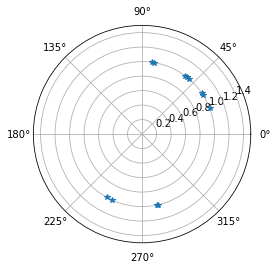

In [27]:
# plot of preferred directions for the 12 cells
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(prf_angs, np.ones(len(prf_angs)), '*')
ax.set_rmax(1.5)
plt.show()

In [28]:
# For each reach, decode the direction of movement from the M rates

# pred_v[0][i] # x component of predicted velocity at time with index t
# pred_v[1][i] # y component of predicted velocity at time with index t
pred_v = np.zeros((2,len(times)))
for idx in range(len(M)):
    pred_v[0,:] += normal_vecs[idx][0]*M_data[idx,:]
    pred_v[1,:] += normal_vecs[idx][1]*M_data[idx,:]

# Obtain the average angle between the predicted and actual velocity
norm_pred_v = pred_v[:,:-idely] # so it has the same length as diff_vec
norm_pred_v = norm_pred_v / np.linalg.norm(norm_pred_v, axis=0) # normalizing
norm_diff_vec = diff_vec / np.linalg.norm(diff_vec, axis=0)
dots = (norm_pred_v * norm_diff_vec).sum(axis=0)  # dot products for all vectors
vel_angs = np.arccos(dots)
mean_dot = np.mean(dots)
mean_vel_ang = np.arccos(mean_dot)
print(mean_vel_ang)

1.5299579761659303


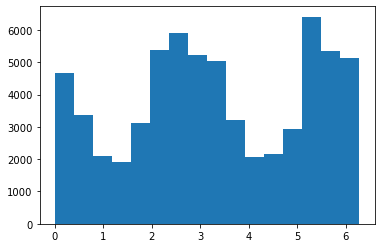

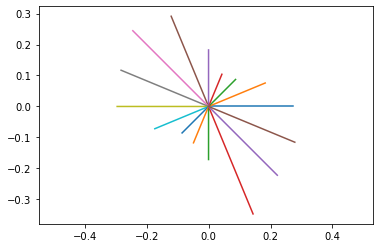

In [29]:
# obtaining "velocity tuning" based on correlations between M rates and directions

# Assuming the cell starting with "We measure velocities for each reach." has been executed,
# so the dv_x and dv_y vectors are already present.

# First we obtain the velocity angle at each simulation step
vel_angs = np.arctan2(dv_y, dv_x)
# Transforming the range of the angles from [-pi,pi] to [0,2pi]
vel_angs = np.mod(vel_angs+2.*np.pi, 2.*np.pi)

# Now we specify in which velocity "bin" each velocity belongs
n_bins = 16 # number of directions
ang_bit = 2.*np.pi/n_bins
vel_bins = np.floor_divide(vel_angs, ang_bit)

# For each direction, count the number of times the hand was following it
# dir_count = np.zeros(n_bins)
# for idx in range(n_bins):
#     dir_count[idx] = np.sum(vel_bins == idx)
dir_count2, edges = np.histogram(vel_angs, bins=n_bins)

# Next, for each angle bin we create an array with all the M activities when the velocity
# was in the corresponding angle.
bin_arrays = []
for ang_bin in range(n_bins):
    bin_arrays.append(M_data[:,ang_bin==vel_bins])

# Finally, we obtain the mean rate of M units for each angle bin
# bin_M_means[i][j]: mean rate of j-th M unit when hand moving in direction of bin i
bin_M_means = []
for ang_bin in range(n_bins):
    if bin_arrays[ang_bin].size > 0:
        bin_M_means.append(np.mean(bin_arrays[ang_bin], axis=1))
    else:
        bin_M_means.append(np.zeros(len(M)))
            
# print histogram for frequency of movement directions
# Using hist. Could compare with dir_count
plt.figure()
#plt.hist(vel_angs, bins=n_bins, range=(0.,1.*np.pi))
plt.hist(edges[:-1], edges, weights=dir_count2)

fig2 = plt.figure()
hist_axs2 = plt.subplot()
hist_axs2.axis('equal')
x_coords = np.cos(edges[:-1]) # x-coordinates of each unit velocity vector
y_coords = np.sin(edges[:-1]) # y-coordinates of each unit velocity vector
norm_dc = dir_count2/np.linalg.norm(dir_count2)
for trg in range(n_bins):
    hist_axs2.plot([0., norm_dc[trg]*x_coords[trg]], [0., norm_dc[trg]*y_coords[trg]])
plt.show()

The reason why the rougly 45 degrees line is favored above is because the hand moves fast and accurately in the orthongonal direction (along the 135 degrees line).  
The hand thus spends little time moving along the 135 degrees line, even though it covers as much, if not more distance along it.

0.9878588706599066
0.8171759392517294
0.9804747055600306
0.9936100727199851
0.8692635121259842
0.7692970871327894
0.9927352494361968
0.9301385795469195
0.9702008892139897
0.9948597573446668
0.8965167474894523
0.6057172503104018


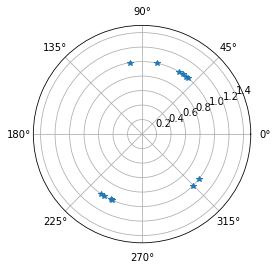

In [30]:
# Preferred directions through planar regression using all velocities

# The M mean rates are fit using a plane, and the preferred angle is the angle
# of the projection of this plane's normal vector onto the XY plane.
# The coefficients of the normal vector come from a 3x3 linear system,
# whose coefficients are calculated next.
angs = np.linspace(0., 2.*np.pi, n_bins, endpoint=False)
trgs = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
X = trgs[:,0].sum()
Y = trgs[:,1].sum()
XY = (trgs[:,0]*trgs[:,1]).sum()
X2 = (trgs[:,0]*trgs[:,0]).sum()
Y2 = (trgs[:,1]*trgs[:,1]).sum()
m = n_bins
Ax = np.array([[X2, XY, X], [XY, Y2, Y], [X, Y, m]])
detA = np.linalg.det(Ax) # determinant of A
if detA == 0.:
    raise ValueError('Indeterminate system found!')
invA = np.linalg.inv(Ax)
# The RHS of the system depends on the M unit's rates
prf_angs3 = np.zeros(len(M)) # preferred angles, in radians
normal_vecs3 = [] # list with the vectors normal to the plane fitting the rates
for idx in range(len(M)): # for each M unit...
    M_means = np.array([bin_M_means[trg][idx] for trg in range(n_bins)]) # means for this unit   
    Rx = (trgs[:,0]*M_means).sum()
    Ry = (trgs[:,1]*M_means).sum()
    R = M_means.sum()
    n = np.matmul(invA, np.array([Rx, Ry, R])) # the normal vector
    normal_vecs3.append(n/np.linalg.norm(n)) # appending normalized vector
    prf_angs3[idx] = np.arctan2(n[1], n[0]) # preferred angle
    # obtaining residuals, coefficient of determination, R^2
    residuals3 = [M_means[trg]-(n[0]*trgs[trg,0]+n[1]*trgs[trg,1]+n[2]) for trg in range(n_bins)]
    avg_mean3 = R/M_means.size
    devs3 = [M_means[trg]-avg_mean for trg in range(n_bins)]
    SSr = sum([r*r for r in residuals3])
    SSt = sum([d*d for d in devs3])
    R = 1. - (SSr/SSt)
    print(R)
    
# plot of preferred directions for the 12 cells
fig_pf3, ax_pf3 = plt.subplots(subplot_kw={'projection': 'polar'})
ax_pf3.plot(prf_angs3, np.ones(len(prf_angs3)), '*')
ax_pf3.set_rmax(1.5)
plt.show()

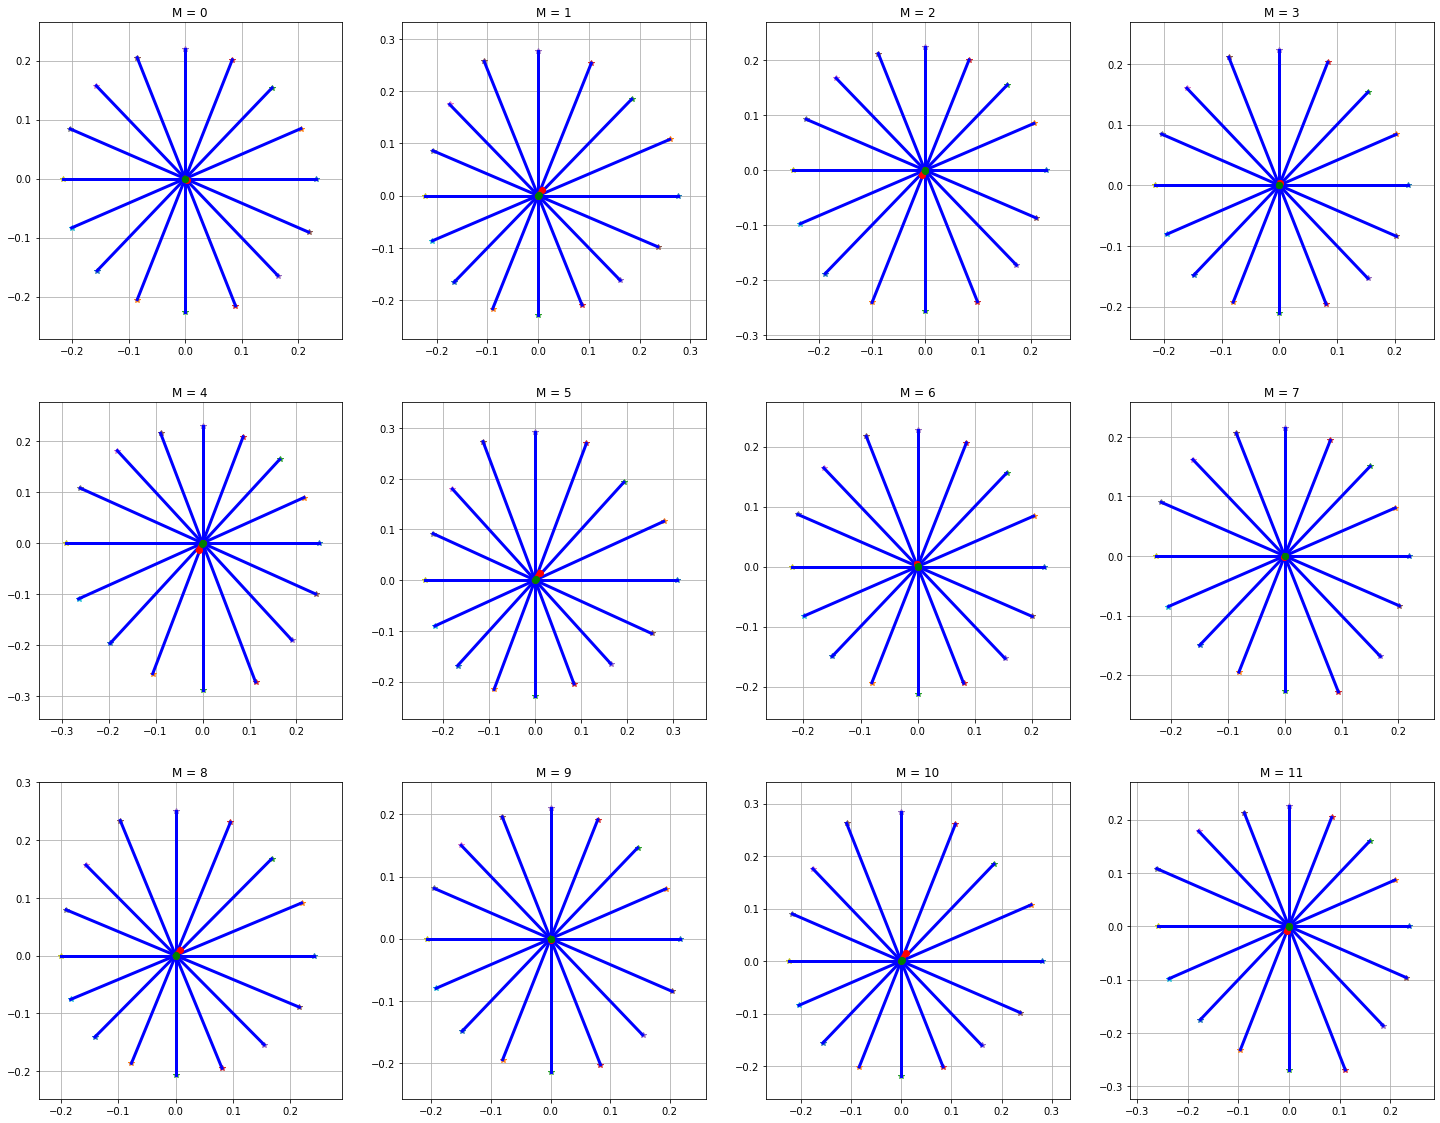

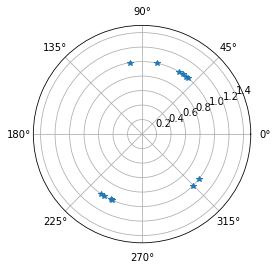

In [31]:
# Plot alternate velocity vector for all M units

# For each velocity angle, get Cartesian coordiantes of its unit vector
angles = np.linspace(0., 2.*np.pi, n_bins+1)[:-1]
x_coords = np.cos(angles) # x-coordinates of each unit velocity vector
y_coords = np.sin(angles) # y-coordinates of each unit velocity vector

# M_coords[i][j][k]: coordinates (j=0, x coordinate; j=1, y coordinate) of
# the i-th unit velocity vector scaled by the mean firing rate of the
# k-th M unit when the hand is moving in the direction of that i-th vector
M_coords = [[bin_M_means[i]*x_coords[i],bin_M_means[i]*y_coords[i]]
            for i in range(n_bins)]

# avg_vels[i][j]: for the i-th M unit the x (if j=0) or y (if j=1)
# coordinate of its preferred velocity vector, arising from an average
# of M_coords[:][j][i]
avg_vels = np.zeros((len(M), 2))
for idx in range(len(M)):
    avg_vels[idx,0] = sum([M_coords[d][0][idx] for d in range(n_bins)])/n_bins
    avg_vels[idx,1] = sum([M_coords[d][1][idx] for d in range(n_bins)])/n_bins

vel_fig, vel_axs = plt.subplots(3, 4, figsize=(fs[0], 3.3*fs[1]))

for row in range(3):
    for col in range(4):
        ax = vel_axs[row][col]
        m_id = 4*row + col
        max_x = max([M_coords[i][0][m_id] for i in range(n_bins)])
        min_x = min([M_coords[i][0][m_id] for i in range(n_bins)])
        max_y = max([M_coords[i][1][m_id] for i in range(n_bins)])
        min_y = min([M_coords[i][1][m_id] for i in range(n_bins)])
        ax.set_xlim([1.2*min_x, 1.2*max_x])
        ax.set_ylim([1.2*min_y, 1.2*max_y])
        ax.grid()
        ax.set_title("M = %d"%(m_id))
        for trg in range(n_bins):
            ax.plot([M_coords[trg][0][m_id]], [M_coords[trg][1][m_id]], '*')
            ax.plot([0., M_coords[trg][0][m_id]], [0., M_coords[trg][1][m_id]], 'b', linewidth=3)
        ax.plot([0., avg_vels[m_id][0]], [0., avg_vels[m_id][1]], 'r-o', linewidth=5)
        avg_norm = np.linalg.norm(avg_vels[m_id][:3])
        ax.plot([0., avg_norm*normal_vecs3[m_id][0]], 
                [0., avg_norm*normal_vecs3[m_id][1]], 'g-o', linewidth=5)
        
# Plot the prefered directions only
prf_angs2 = np.arctan2(avg_vels[:,1], avg_vels[:,0])
prf_dir2_fig, prf_dir2_ax = plt.subplots(subplot_kw={'projection': 'polar'})
prf_dir2_ax.plot(prf_angs2, np.ones(len(prf_angs2)), '*')
prf_dir2_ax.set_rmax(1.5)

plt.show()

In [32]:
# Once more, predict velocities
# pred_v2[i][j]: x (if i=0) or y (if i=1) component of predicted
# velocity at time index 'j'
pred_v2 = np.zeros((2,len(times)))
for idx in range(len(M)):
    pred_v2[0,:] += avg_vels[idx][0]*M_data[idx,:]
    pred_v2[1,:] += avg_vels[idx][1]*M_data[idx,:]

# Obtain the average angle between the predicted and actual velocity
norm_pred_v2 = pred_v2[:,:-idely] # so it has the same length as diff_vec
norm_pred_v2 = norm_pred_v2 / np.linalg.norm(norm_pred_v2, axis=0) # normalizing
norm_diff_vec = diff_vec / np.linalg.norm(diff_vec, axis=0)
dots2 = (norm_pred_v2 * norm_diff_vec).sum(axis=0)  # dot products for all vectors
vel_angs2 = np.arccos(dots2)
mean_dot2 = np.mean(dots2)
mean_vel_ang2 = np.arccos(mean_dot2)
print(mean_vel_ang2)


1.5395949813948804


In [33]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to E spinal units")
for idx, syn in enumerate(net.syns[CE[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    elif pre_id in ACT:
        pre_pop = 'ACT'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

print("Connections to I spinal units")
for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.bouncy_planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    elif pre_id in ACT:
        pre_pop = 'ACT'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns):
    if len(syn) == 0:
        break
    pre_id = syn[0].preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn[0].w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

Connections to motor units
0) A (0) --> M, w=0.071765, port=2, plant_out=None
1) A (1) --> M, w=0.079429, port=2, plant_out=None
2) A (2) --> M, w=0.288592, port=2, plant_out=None
3) A (3) --> M, w=0.295095, port=2, plant_out=None
4) A (4) --> M, w=0.098864, port=2, plant_out=None
5) A (5) --> M, w=0.236378, port=2, plant_out=None
6) A (6) --> M, w=0.176115, port=2, plant_out=None
7) A (7) --> M, w=0.222284, port=2, plant_out=None
8) A (8) --> M, w=0.091306, port=2, plant_out=None
9) A (9) --> M, w=0.133590, port=2, plant_out=None
10) A (10) --> M, w=0.142778, port=2, plant_out=None
11) A (11) --> M, w=0.163803, port=2, plant_out=None
12) SPF (62) --> M, w=1.000000, port=1, plant_out=None
-------------------------

Connections to afferent units
0) A (0) --> A, w=2.000000, port=0, plant_out=None
-------------------------

Connections to E spinal units
0) ACT (24) --> CE, w=1.000000, port=2, plant_out=None
1) CI (31) --> CE, w=-1.300000, port=1, plant_out=None
2) CE (26) --> CE, w=1.0000

In [105]:
# prepare data for animation
from numpy import cos, sin
if not 'targets' in locals():
    targets = np.array([[0.3, 0.3]])
start_time = 0.
start_idx = int(start_time/net.min_delay)
fdelay = 4000 # number of frames to plot for hand trajectory
# angles of shoulder and elbow
theta_s = arm_activs[start_idx:,0]
theta_e = arm_activs[start_idx:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
#acts = np.array(data[1])
ipx = data[ipx_track,start_idx:]
ipy = data[ipy_track,start_idx:]
ten = arm_activs[start_idx:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2


In [106]:
#Animation of the arm and muscles
%matplotlib widget
from matplotlib.animation import FuncAnimation
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-.2, lim])
ax.set_ylim([-.2, lim])
ax.grid()
ax.scatter(targets[:,0], targets[:,1], s=150, c='cyan')
# creating lines and points
line, = ax.plot([], [], 'o-k', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
traj, = ax.plot([], [], 'tab:gray', lw=1)
pred_vel, = ax.plot([], [], 'r-o')
ax.scatter([0.3], [0.3], s=200, c='cyan')
# preparing a colormap for the tensions
ten_max = np.mean(np.max(ten, axis=1))
ten_min = np.mean(np.min(ten, axis=1))
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
#strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs
strt_idx = int(np.round((times[0]+start_time)/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    traj.set_data([], [])
    pred_vel.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    #traj.set_data(xh[0:frame], yh[0:frame])
    #traj.set_data(xh[frame-max(0,frame-fdelay):frame], yh[frame-max(0,frame-fdelay):frame])
    if frame > fdelay:
        traj.set_data(xh[frame-fdelay:frame], yh[frame-fdelay:frame])
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = (frame+start_idx)*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    #cur_idx = int(cur_time/t_pres) + strt_idx
    #cur_idx = int(frame*net.min_delay/t_pres) + strt_idx
    cur_idx = int(frame*net.min_delay/t_pres)  # if using new targets
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    # plotting predicted velocity
    #pred_vel.set_data([xh[frame], xh[frame]+0.3*pred_v[0][frame]], [yh[frame], yh[frame]+0.3*pred_v[1][frame]])
    #pred_vel.set_data([xh[frame], xh[frame]+5.*pred_v2[0][frame]], [yh[frame], yh[frame]+5.*pred_v2[1][frame]])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

#plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [107]:
# alternate way to display the animation
from IPython.display import HTML
#HTML(ani.to_jshtml(fps=20))
HTML(ani.to_html5_video())

In [23]:
# save the animation
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Sergio Verduzco'), bitrate=2000)
ani.save('/home/z/Dropbox (OIST)/saves/no_noise_6-22.mp4', writer=writer)

In [ ]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=0*200
second_idx=5*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [ ]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

In [23]:
X_init_idx = 0
X_end_idx = X_init_idx + int(1./net.min_delay) # one second
X = data[M[0]:M[6], X_init_idx:X_end_idx].transpose()

In [24]:
X.shape

(200, 6)

In [25]:
data[M[0]:M[6],X_init_idx:X_end_idx].shape

(6, 200)

In [ ]:
# jPCA analysis part 1

import scipy as sp
n = 6 # number of dimensions to consider in M
t_smp = .2 # time to sample M (in seconds)
X_init_idx = 0 # index of time where M sample begins
X_end_idx = X_init_idx + int(t_smp/net.min_delay) # t_smp seconds later

X = data[M[0]:M[n], X_init_idx:X_end_idx].transpose()
t_points = times[X_init_idx:X_end_idx]
# standardize the X data
X = X - np.mean(X)
X = X / np.std(X)

# create the block-matrix version of X
Xtilde = sp.linalg.block_diag(*([X]*n))

# Create the H matrix
n = X.shape[1]
ct = X.shape[0]
L = np.zeros((n,n), dtype=int)
c = 0
for row in range(n):
    for col in range(row+1, n):
        L[row, col] = c
        L[col, row] = c
        c += 1
        
H = np.zeros((n*n, int(0.5*n*(n-1))))
for col in range(n):
    for row in range(n):
        if col > row:
            H[n*col+row, L[col,row]] = 1.
        elif row > col:
            H[n*col+row, L[col,row]] = -1.
            
# Approximate the derivatives of X
Xp = np.zeros_like(X)
t_bit = t_points[1] - t_points[0]
Xp[1:,:] = (X[1:,:] - X[:-1,:]) / t_bit

xp = Xp.flatten('F')

kstar = np.matmul(np.linalg.pinv(np.matmul(Xtilde, H)), xp)

# reconstruct the matrix that generated the data
Mstar = np.matmul(H, kstar).reshape(n,n)

In [ ]:
# jPCA analysis part 2

# Next,extract the eigenvalues of M.
eig_vals, eig_vecs = np.linalg.eig(Mstar)
print(Mstar)
print("Eigenvalues: ")
print(eig_vals)
print("Eigenvectors: ")
print(eig_vecs)

eig_vals_norms = np.sqrt((eig_vals * eig_vals.conj()).real)
ev_sum = eig_vals_norms.sum()/2.
var_percentages = eig_vals_norms[np.array([0,2,4])] / ev_sum
print("Variance percentages by each conjugate eigenvalue pair")
print(var_percentages)

# We obtain the plane of strongest rotations
srt_idxs = np.argsort(-eig_vals_norms) # indexes for sorting in decreasing order
srt_eig_vecs = eig_vecs[:, srt_idxs]
u1 = (srt_eig_vecs[:,0] + srt_eig_vecs[:,1]).real
u2 = (1j * (srt_eig_vecs[:,0] - srt_eig_vecs[:,1])).real
u1 = u1 / np.linalg.norm(u1)
u2 = u2 / np.linalg.norm(u2)

# project the data onto u1 and u2
u1_proj = (X * u1).sum(axis=1)
u2_proj = (X * u2).sum(axis=1)

In [ ]:
# jPCA analysis part 3

# Sort the data in X according to "preparatory activity"
# to simplify, we use 

In [ ]:
srt_idxs = np.argsort(-eig_vals_norms) # indexes for sorting in decreasing order
srt_eig_vecs = eig_vecs[:, srt_idxs]
u1 = (srt_eig_vecs[:,0] + srt_eig_vecs[:,1]).real
u2 = (1j * (srt_eig_vecs[:,0] - srt_eig_vecs[:,1])).real
print(u1)
print(u2)

In [ ]:
u1_proj.shape

In [ ]:
w_sum = 0.
for syn in net.syns[C[0]]:
    if syn.type is synapse_types.rga_21:
        w_sum += syn.w
        
print(w_sum)

n_syns = 0
for syn_list in net.syns:
    for syn in syn_list:
        n_syns += 1
print(n_syns)
print(len(net.units))

In [ ]:
import cProfile
import pstats
sim_time = 5.
start_time = time.time()
#cProfile.run('times, data, _  = net.run(sim_time)', 't2p3stats')
cProfile.run('times, data, plant_data  = net.flat_run(sim_time)', 'v3ft3p2_stats')
#times, data, _  = net.run(sim_time)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

In [ ]:
p = pstats.Stats('v3ft3p2_stats')
p.sort_stats('cumtime').print_stats(50)

In [ ]:
# restore A__M connections
for mid in M:
    for syn in net.syns[mid]:
        if syn.type is synapse_types.inp_sel:
            syn.w_sum = 2.5
            syn.w_max = 1.2
            syn.l_rate = 10.
            syn.alpha = syn.l_rate * net.min_delay

---